In [1]:
import numpy as np
import math
import sys
from tqdm import tqdm
import pdb #pdb.set_trace() #delete this line for the final version

In [2]:
def Readfile():
    #read binary file
    finTrainImg = open('./dataset/train-images-idx3-ubyte',mode='rb')
    finTrainLb = open('./dataset/train-labels-idx1-ubyte',mode='rb')
    finTestImg = open('./dataset/t10k-images-idx3-ubyte',mode='rb')
    finTestLb = open('./dataset/t10k-labels-idx1-ubyte',mode='rb')

    #deal with training headers
    finTrainImg.seek(4,0) #first 4 bytes are the header of magic number = 0x00000803 which means the following data type is unsigned byte(meaning of 0x08) and there will be three dimensions(meaning of 0x03); to skip this header, we initially seek 4 bytes from the start of the train image file
    finTrainLb.seek(8,0) #first 4 bytes are the header of magic number. second 4 bytes are the header of first dimension, number of images, which will be defined later; to skip these headers, we initially seek 8 bytes from the start of the train lable file
    nTrainImg=int.from_bytes(finTrainImg.read(4), byteorder='big') #second 4 bytes are the header of first dimension, number of images = 0x0000ea60 = 0d60000
    #nTrainImg=100 #delete
    #finTrainImg.seek(4,1) #delete
    nRow=int.from_bytes(finTrainImg.read(4), byteorder='big') #third 4 bytes are the header of second dimension, number of rows = 0x0000001c = 0d28
    nCol=int.from_bytes(finTrainImg.read(4), byteorder='big') #forth 4 bytes are the header of third dimension, number of columns = 0x0000001c = 0d28
    
    #deal with training data and parse them
    trainImg=np.zeros((nTrainImg,nRow,nCol),dtype='uint8') #there are 60000 images; each image has 28*28 pixels; each pixel's size is 1 byte, though unit8's memory size is larger than 1 byte ... it's python's drawback
    trainLb=np.zeros(nTrainImg,dtype='uint8') #there are 60000 images, so there are also 60000 labels
    for i in tqdm(range(nTrainImg)):
        for j in range(nCol):
            for k in range(nRow):
                trainImg[i][j][k]=int.from_bytes(finTrainImg.read(1), byteorder='big') #actually, byteorder here can be either big or liitle, because there is just "1" byte    
        trainLb[i]=int.from_bytes(finTrainLb.read(1), byteorder='big')
    finTrainImg.close()
    finTrainLb.close()

    #same logic, deal with testing headers and data
    finTestImg.seek(4,0)
    finTestLb.seek(8,0)
    nTestImg=int.from_bytes(finTestImg.read(4), byteorder='big')  #second 4 bytes are the header of first dimension, number of images = 0x00002710 = 0d10000
    #nTestImg=100 #delete
    #finTestImg.seek(4,1) #delete
    finTestImg.seek(8,1) #nRow and nCol are the same as Training data
    testImg=np.zeros((nTestImg,nRow,nCol),dtype='uint8') #there are 60000 images; each image has 28*28 pixels; each pixel's size is 1 byte, though unit8's memory size is larger than 1 byte ... it's python's drawback
    testLb=np.zeros(nTestImg,dtype='uint8') #there are 60000 images, so there are also 60000 labels
    for i in tqdm(range(nTestImg)):
        for j in range(nCol):
            for k in range(nRow):
                testImg[i][j][k]=int.from_bytes(finTestImg.read(1), byteorder='big') #actually, byteorder here can be either big or liitle, because there is just "1" byte    
        testLb[i]=int.from_bytes(finTestLb.read(1), byteorder='big')
    finTestImg.close()
    finTestLb.close()
    
    return ((trainImg,trainLb),(testImg,testLb),nRow,nCol)

#### Naive Bayes Classifier ####

**we want to find the most potential lable given a testImage**
$$
\begin{aligned}
label^* &= argmax_{label}P(label|testImage)\because \text{bayes theorem} \\
&= argmax_{label}\frac{P(testImage|label)*P(label)}{P(testImage)} \because P(testImage)\text{ is irrelevant to label}\\
&=argmax_{label}P(testImage|label)*P(label)
\end{aligned}
$$
**and print out each label's probability given a particular testImage where** 

$\text{pbgt}=\text{particular (bin) of gray level from testImage}$

$\text{prior}=P(label)=\frac{\text{amount of training images of the label appear}}{\text{total amount of training image}}\text{ , the percentage of each label in the training dataset}$

$\text{particular image's likelihood}=P(testImage|label)\\=P(1^{st} pixel=pbgt , 2^{nd} pixel=pbgt , ... , and (28*28)^{th} pixel=pbgt|label\text{ , each pixel's gray level is between 0 and 255)}  \\\text{ps. there are }256^{784} \text{possible images}$

**assume all the features (28*28 pixels) is independent in the condition of that label (the essence of naive bayes classifier)**

$\approx P(1^{st} pixel=pbgt|label) * P(2^{nd} pixel=pbgt|label) * P(3^{rd} pixel=pbgt|label) * ... * P((28*28)^{th} pixel=pbgt|label)$

**in discrete mode:**

we parse each pixel's gray level (0-255) into 32 bins (0-7,8-15,...)

$\approx P(1^{st} pixel=pbgt , 2^{nd} pixel=pbgt , ... , and (28*28)^{th} pixel=pbgt|label\text{ , each pixel's bin of gray level is between 0 and 31)}  \\\text{ps. there are }32^{784} \text{possible images}$

$\text{particular pixel's likelihood} = P(n^{th} pixel=pbgt|label) = \frac{\text{count of } n^{th} \text{ pixel=(pbgt) under training image's particular label}}{\text{sum of }n^{th} \text{ pixel's count of each bin of gray level under training image's particular label}}$

**in continuous mode:**

in this case, every pixel has its own Gaussian distribution with ($\mu$=mean of each value of the pixel under a particular label, $\sigma^2$ variance of each value of the pixel under a particular label)

$\text{particular pixel's likelihood}=P(n^{th} pixel=pbgt|label)=\frac{1}{\sigma \sqrt{2\pi}}exp({-\frac{(n^{th}pixel-\mu)^2}{2\sigma^2})}$

the reason why we don't need to multiply probability density function of Gaussian(height) by $\Delta x$(width) to reach the definition of probability is because we just interest in the relative likelihood that a pixel belongs to each labels
$$
P(label|testImage)=\frac{(P(testImage|label)*\Delta x)*P(label)}{\sum_{label}(P(testImage|label)*\Delta x)*P(label)}=\frac{P(testImage|label)*P(label)}{\sum_{label}P(testImage|label)*P(label)}
$$
**because log is monotonic, we can add log scale on the posterior to avoid underflow**
$$
\begin{aligned}
\text{log posterior}&=log P(label|testImage) \\
&=log(\frac{P(testImage|label)*P(label)}{P(testImage)}) \\
&\because \text{log posterior's denominator }P(testImage)\text{ is irrelevant to each label's probability} \\
&\therefore \text{we can just use log posterior's numerator instead of whole log posterior} \\ 
&\propto log(P(testImage|label)*P(label))\\
\end{aligned}
$$

**we use log posterior's numerator to represents each label's probability, but the sum of each log posterior's numerator isn't equal to 1 which is opposed to the probability's definition**

**we hope the output of sum of each label's probability is equal to 1, so we multiply each log posterior's numerator by $\alpha(\alpha<0)$ to achieve normalization**
$$
\begin{align}
1&=\alpha \sum_{label}log(P(testImage|label)*P(label)) \\
\therefore \alpha &=\frac{1}{\sum_{label}log[P(testImage|label)*P(label)]}
\end{align}
$$
**which means that each label's probability under the particular testImage is equivalent to multiply each log posterior's numerator by $\alpha$**
$$
\begin{aligned}
\text{normalized log posterior} &=\alpha*log[P(testImage|label)*P(label)]
\end{aligned}
$$
**we can calculate the posterior based on each pixel's likelihood instead of an image's likelihood,**
$$
\begin{aligned}
&=\alpha*\{log[(P(1^{st} pixel=pbgt|label) * P(2^{nd} pixel=pbgt|label) * ... * P((28*28)^{th} pixel=pbgt|label)) * P(label)]\} \\
&=\alpha*\{logP(1^{st} pixel=pbgt|label) + logP(2^{nd} pixel=pbgt|label) + ... + logP((28*28)^{th} pixel=pbgt|label) + logP(label)\}
\end{aligned}
$$
**based on the above statement, the most potential lable can be derived in this way**
$$
\begin{aligned}
label^* &=argmax_{label}P(testImage|label)*P(label) \because \text{log is a monotonic function}\\
&=argmax_{label}log[P(testImage|label)*P(label)] \because \alpha<0\\
&=argmin_{label}\alpha*log[P(testImage|label)*P(label)]\\
&=argmin_{label} \text{ normalized log posterior} \\
&\therefore \text{normalized log posterior's corresponding order of each label's probability is reverse}
\end{aligned}
$$

In [3]:
def Imagination(likePixelProb,modelParameter):
    fout=open('./dataset/out_Imagination.txt',mode='w')#sys.stdout#
    #Imagination of Naive Bayes Classifier
    #after getting each pixel's each bin of gray level's likelihood, we can get the imagination of numbers in our naive Bayes classifier
    #each pixel's bin of gray level is the one that makes this pixel's bin of gray level's likelihood maximum
    (nRow,nCol,nLabel,_,_,_,_)=modelParameter
    nBins=likePixelProb.shape[3] #discrete=32,continuous=256
    for label in range(nLabel): #deal with each number imagination
        for x in range(nRow):
            for y in range(nCol):
                vBin=np.argmax(likePixelProb[label][x][y][:])
                if vBin>=(nBins/2):
                    print("1",end=" ",file=fout)
                else:
                    print("0",end=" ",file=fout)
            print(" ",file=fout)
        print("\n",file=fout)
    fout.close()

In [4]:
def Prior(trainLb,modelParameter):
    (_,_,nLabel,_,_,_,_)=modelParameter
    #prior : the percentage of each label in the training dataset
    priorProb=np.zeros(nLabel)
    for label in range(nLabel):
        priorProb[label]=np.sum(trainLb==label)/len(trainLb)
    return priorProb

In [5]:
def LikePixel_Discrete(trainImg,trainLb,modelParameter):
    (nRow,nCol,nLabel,nBins,nPixelValue,_,_)=modelParameter
    divBin=int(nPixelValue/nBins)
    #particular pixel's likelihood : calculate the likelihood of each pixel's bin of gray level in the training dataset
    likePixelProb=np.zeros((nLabel,nRow,nCol,nBins))
    #nominator , classify all the image into each of label, and count the amount of each pixel's bin of gray level under the particular label
    for i in tqdm(range(len(trainImg))): #each training image
        label=trainLb[i] #attach to the particular label
        for x in range(nRow): #each pixel
            for y in range(nCol):
                locBin=trainImg[i][x][y]//divBin #parse each pixel's value into 32 bins
                likePixelProb[label][x][y][locBin]+=1 #count the amount of this pixel's bin of gray level
    #denominator , count all the possible bins of gray level of each label's each pixel
    for label in range(nLabel): #each label
        for x in range(nRow): #each pixel
            for y in range(nCol):
                sumBin=0
                for iBin in range(nBins): #sum up all this pixel's possible bin of gray level
                    sumBin+=likePixelProb[label][x][y][iBin]
                likePixelProb[label][x][y][:]/=sumBin
    return likePixelProb

In [6]:
def gaussian(x,mean,variance):
    return ((1/math.sqrt(2*math.pi*variance))*math.exp((-(x-mean)**2)/(2*variance)))

In [7]:
def LikePixel_Continuous(trainImg,trainLb,modelParameter):
    (nRow,nCol,nLabel,_,nPixelValue,minVar,_)=modelParameter
    likePixelProb=np.zeros((nLabel,nRow,nCol,nPixelValue))
    #debug1=np.zeros((nLabel,nRow,nCol))
    for label in tqdm(range(nLabel)):
        for x in range(nRow):
            for y in range(nCol):
                mean=np.mean(trainImg[label==trainLb][:,x,y]) # you can't write trainImg[label==trainLb][:][x][y], because X[:] is just to cut the sample space(eg. 3x3 -> 2*3), not dereference. therefore, X[:][0:3]=X[0:3], X[:][0]!= X[:,0]
                variance=np.var(trainImg[label==trainLb][:,x,y])+minVar # to avoid gaussian divide by zero, variance should be zero, but it can't be to small, because it will be put on the exponential term, or it will be e^-(1/(0.001=1e-3))=e^-(1e+3) which leads to underflow and can not calculate likelihood efficently
                #debug1[label][x][y]=variance
                for p in range(nPixelValue):
                    likePixelProb[label][x][y][p]=gaussian(p,mean,variance) #because this Guassian distribution so sharp that all the probability is equal to mean; the values of probability density function can be greater than one. the actual probability P(X<x) should be an intergral. https://stats.stackexchange.com/questions/9427/interpreting-gaussian-probabilities-greater-than-1
    #debug2=np.reshape(debug1,(nLabel*nRow*nCol)) #check debug2[(debug2<1) & (debug2>0)]
    return likePixelProb

In [8]:
def NaiveBayesClassifier(trainImg,trainLb,testImg,testLb,modelParameter,toggle):
    #Naive Bayes Classifier in discrete mode
    fout=open('./dataset/out_NaiveBayesClassifier.txt',mode='w')#sys.stdout#
    (nRow,nCol,nLabel,_,_,_,minNum)=modelParameter
    
    #prior
    priorProb=Prior(trainLb,modelParameter)
    #each of particular pixel's likelihood
    if toggle==0:
        likePixelProb=LikePixel_Discrete(trainImg,trainLb,modelParameter)
    else:
        likePixelProb=LikePixel_Continuous(trainImg,trainLb,modelParameter)
    #normalized log posterior
    error=0
    for i in tqdm(range(len(testImg))): #each testing image
        posteriorLogProbNumerator=np.zeros(nLabel)
        for label in range(nLabel): #calcalate each lable's posterior's numerator
            #each of particular image's likelihood
            likeImageLogProb=0
            for x in range(nRow):
                for y in range(nCol):
                    if(toggle==0):
                        divBin=int(nPixelValue/nBins)#256(=1byte) is the size of each pixel which is defined in the dataset
                        locBin=testImg[i][x][y]//divBin #see which bin the testing image's each pixel is locate on
                        likeImageLogProb+=np.log(max(minNum,likePixelProb[label][x][y][locBin])) #calculate the log probability of likelihood by adding each log probability of pixel's likelihood; the reason why we can directly add the log probability is because of conditionaly independence; why we need lower bound? the domain of a logarithmic function is larger than zero, so each bin's minimum value is larger than zero
                    else:
                        locPixel=testImg[i][x][y]
                        likeImageLogProb+=np.log(max(minNum,likePixelProb[label][x][y][locPixel]))#minNum can't be too small, because the likePixelProb derived from Gaussian can be small to 1e-300. also, python's underflow is 1e-3xx
            #log posterior's numerator = log(particular image's likelihood * prior) = log(particular image's likelihood) * log(prior)
            posteriorLogProbNumerator[label]=likeImageLogProb+np.log(priorProb[label])
        #normalize the log posterior : because it is divided by the sum of posterior's numerator which is negative, the probability of each label is the reverse order of normalized log posterior
        normPosteriorLogProb=posteriorLogProbNumerator/np.sum(posteriorLogProbNumerator)
        #pick the most potential label under this given testImage which is the minimal normalized log posterior
        predict=np.argmin(normPosteriorLogProb)
        #caculate total error
        error+=(predict!=testLb[i])
        
        #print each label's probability in log scale
        for label in range(nLabel):
            print(label,": ",normPosteriorLogProb[label],file=fout)
        print("Prediction: ",predict, " Ans: ", testLb[i],end="\n\n",file=fout)
    #print this classifier's error rate
    errorRate=error/len(testImg)
    print("Error rate: ",errorRate,file=fout)
    fout.close()
    #print imaignation of each label under this classifier
    Imagination(likePixelProb,modelParameter)

In [9]:
if __name__=='__main__':
    #initialize
    ((trainImg,trainLb),(testImg,testLb),nRow,nCol)=Readfile()
    nLabel=10
    nPixelValue=256
    nBins=32
    minVar=10#1e-1#100 or 1000 is better
    minNum=1e-30#1e-10
    modelParameter=(nRow,nCol,nLabel,nBins,nPixelValue,minVar,minNum)
    
    #implement Naive Bayes Classifier
    toggle=int(input('Toggle option (0:discrete / 1:continuous): '))
    NaiveBayesClassifier(trainImg,trainLb,testImg,testLb,modelParameter,toggle)

100%|██████████| 10000/10000 [00:15<00:00, 645.89it/s]


Toggle option (0:discrete / 1:continuous):  0


100%|██████████| 10000/10000 [11:48<00:00, 14.10it/s]


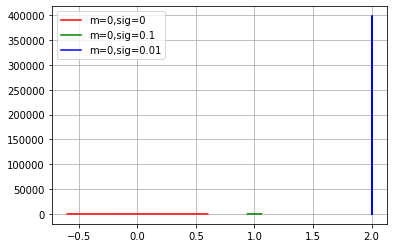

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math


def normal_distribution(x, mean, sigma):
    return np.exp(-1*((x-mean)**2)/(2*(sigma**2)))/(math.sqrt(2*np.pi) * sigma)


mean1, sigma1 = 0, 0.1
x1 = np.linspace(mean1 - 6*sigma1, mean1 + 6*sigma1, 100)

mean2, sigma2 = 1, 0.01
x2 = np.linspace(mean2 - 6*sigma2, mean2 + 6*sigma2, 100)

mean3, sigma3 = 2, 1e-6
x3 = np.linspace(mean3 - 6*sigma3, mean3 + 6*sigma3, 100)

y1 = normal_distribution(x1, mean1, sigma1)
y2 = normal_distribution(x2, mean2, sigma2)
y3 = normal_distribution(x3, mean3, sigma3)

plt.plot(x1, y1, 'r', label='m=0,sig=0')
plt.plot(x2, y2, 'g', label='m=0,sig=0.1')
plt.plot(x3, y3, 'b', label='m=0,sig=0.01')
plt.legend()
plt.grid()
plt.show()